In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import SensitivityMatrix, AET1SensitivityMatrix, AE1SensitivityMatrix
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD
from bbhx.utils.interpolate import CubicSplineInterpolant

import noise_generation as noise_generation
from tools.LISASimulator import LISASimulator
from tools.likelihood import get_dh, get_hh
import tools.likelihood as likelihood

from tools.time_freq_likelihood import TimeFreqLikelihood

No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU response available.


In [2]:
Tobs = YRSID_SI/12
dt = 5.
include_T_channel = False # Set to True if you want to include the T channel in the simulation, otherwise only A and E channels will be included.

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

m1 = 3e5
m2 = 1.5e5
a1 = 0.2
a2 = 0.4
dist = 8e3 * PC_SI * 1e6 
phi_ref = np.pi/2
f_ref = 0.0
inc = np.pi/3
lam = np.pi/1.
beta = np.pi/4.
psi = np.pi/4.
t_ref = 0.95 * Tobs
#t_ref = round(0.9 * Tobs / dt) * dt  # round to the nearest multiple of dt, to force t_ref to be a part of t_array

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(direct=False, fill=True, squeeze=False, length=1024)

data_t, data_f, f_array, t_array, sens_mat = sim(seed = 42, parameters=parameters, modes=modes, waveform_kwargs=waveform_kwargs)

In [3]:
nperseg = 5000
time_before_merger = 60*60*24
cutoff_time = t_ref - time_before_merger
max_time = cutoff_time + 60*60*24*2

[1797.74220323]
1797.6542376148095


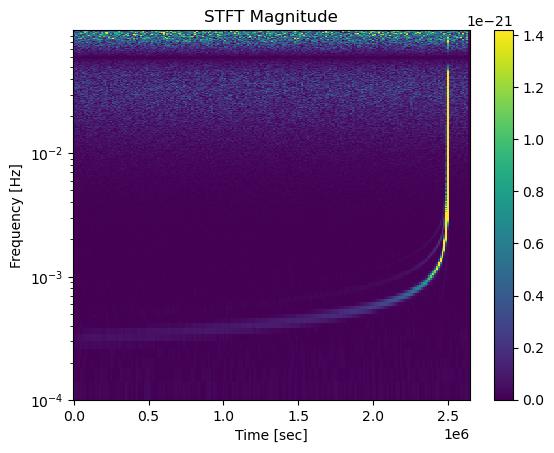

In [4]:
sim.plot_time_frequency(nperseg=nperseg)
print(sim.SNR_optimal())
print(likelihood.template_snr(data_f, sim.signal_f, AE1SensitivityMatrix(f_array), df=sim.df))

In [5]:
# Check is the likelihood is zero by computing the likelihood of a template with the true parameters with the noise-free signal.
analysis_no_noise = TimeFreqLikelihood(data_t=sim.signal_t[0], wave_gen=wave_gen)
analysis_no_noise.get_stft_of_data()
analysis_no_noise.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        direct=False,
        fill=True,
        squeeze=False,
        freqs=f_array,
        modes=modes
    )
)

np.float64(0.0)

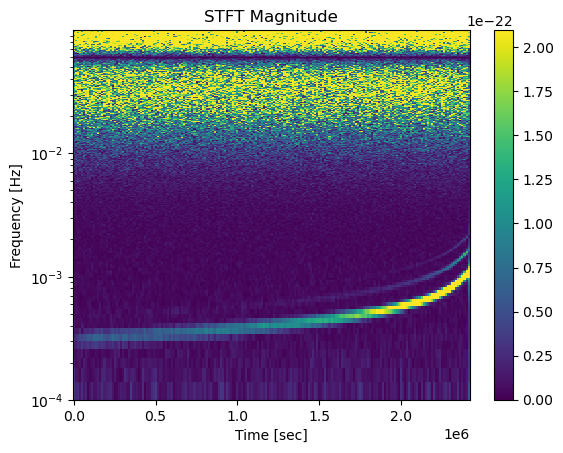

In [6]:
analysis = TimeFreqLikelihood(data_t=data_t, wave_gen=wave_gen, nperseg=nperseg)
analysis.pre_merger(time_before_merger=time_before_merger, t_ref=t_ref, t_array=t_array, )
analysis.get_stft_of_data()
analysis.plot_spectrogram()

In [7]:
print("Best likelihood (true parameters)= ", analysis.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=f_array,
        modes=modes
    )
))
print("Likelihood of a random template = ", analysis.calculate_time_frequency_likelihood(
    m1 *20* (1 + 1e-7 * np.random.randn(1))[0],
    m2 * (1 + 1e-7 * np.random.randn(1))[0], 
    a1,
    a2,
    dist * 10, 
    phi_ref * (1 + 1e-7 * np.random.randn(1))[0],
    f_ref, 
    inc,
    lam*2,
    beta,
    psi,
    t_ref * (1 + 1e-7 * np.random.randn(1))[0],
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=f_array,
        modes=modes
    )
))#/analysis.dt

Best likelihood (true parameters)=  -38.60062399816447
Likelihood of a random template =  -94.38084290393186


In [8]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [9]:
def likelihood(x, freqs, TimeFreqLikelihood_object):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[2] = x[2]
    all_parameters[3] = x[3]
    all_parameters[4] = x[4] * PC_SI * 1e6 
    all_parameters[5] = x[5]
    all_parameters[6] = x[6]
    all_parameters[7] = x[7]
    all_parameters[8] = x[8]
    all_parameters[9] = np.arcsin(x[9])
    all_parameters[10] = x[10]
    all_parameters[11] = x[11]

    ll = TimeFreqLikelihood_object.calculate_time_frequency_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
        length=1024, 
        direct=False,
        fill=True,
        squeeze=False,
        freqs=freqs,
        modes=modes
        )
    )
    return ll

In [10]:
priors = {"mbh": ProbDistContainer({
    0 : uniform_dist(1e5, 1e6),                  # mT = m1 + m2
    1 : uniform_dist(0.05, 0.999999),            # q = m2/m1
    2 : uniform_dist(-0.99999999, +0.99999999),  # a1
    3 : uniform_dist(-0.99999999, +0.99999999),  # a2
    4 : uniform_dist(1e3, 10e3),                 # dist in Mpc
    5 : uniform_dist(0.0, 2 * np.pi),            # phi_ref
    6 : uniform_dist(-1.0, 1.0),                 # f_ref
    7 : uniform_dist(0.0, np.pi),                # inc
    8 : uniform_dist(0.0, 2 * np.pi),            # lam
    9 : uniform_dist(-1.0, 1.0),                 # beta    
    10: uniform_dist(0.0, np.pi),                # psi
    11: uniform_dist(cutoff_time, max_time),     # t_ref
})}

periodic = {"mbh": {5: 2 * np.pi,
                    8: 2 * np.pi,}}

ntemps = 10
nwalkers = 32
nsteps = 10
ndims = {"mbh": 12}

In [11]:
x = priors["mbh"].rvs(size=(nwalkers))[0]
x, likelihood(x, f_array, analysis)

(array([ 1.29077806e+05,  8.07822807e-01, -4.57027828e-01, -5.23030195e-02,
         6.01714204e+03,  6.16379631e+00, -6.42718045e-01,  7.76622531e-01,
         2.51604632e+00,  5.01110401e-01,  3.09103533e+00,  2.56134904e+06]),
 np.float64(-149.21810988358604))

In [12]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood,
    priors,
    args=(f_array, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [17]:
injection_params_sub = np.array([m1+m2, 
                                 m2/m1, 
                                 a1, 
                                 a2, 
                                 dist / (PC_SI * 1e6), 
                                 phi_ref, 
                                 f_ref, 
                                 inc, 
                                 lam, 
                                 (beta), 
                                 psi, 
                                 t_ref])
#start_params = injection_params_sub[None, None, None, :] * (1 + 0.1 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))

start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))

#start_params[:, :, :, 0] = injection_params_sub[None, None, None, 0] * (1 + 0.1 * np.random.randn(ntemps, nwalkers, 1))
#start_params[:, :, :, 1] = injection_params_sub[None, None, None, 0] * (1 + 0.1 * np.random.randn(ntemps, nwalkers, 1))

#start_params[:, :, :, 2] = injection_params_sub[None, None, None, 2] * (1 + 0.01 * np.random.randn(ntemps, nwalkers, 1))

#start_params[..., 2] = np.random.uniform(cutoff_time, max_time, size=(ntemps, nwalkers, 1))

start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)

array([[-43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829],
       [-43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43.56152829, -43.56152829,
        -43.56152829, -43.56152829, -43

In [18]:
sampler.run_mcmc(start_state, nsteps=nsteps, progress=True)

100%|██████████| 10/10 [14:54<00:00, 89.47s/it]


/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/chainconsumer/plotter.py:864: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(base.extents[p1])
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/chainconsumer/plotter.py:865: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(base.extents[p2])
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


IndexError: index 0 is out of bounds for axis 0 with size 0

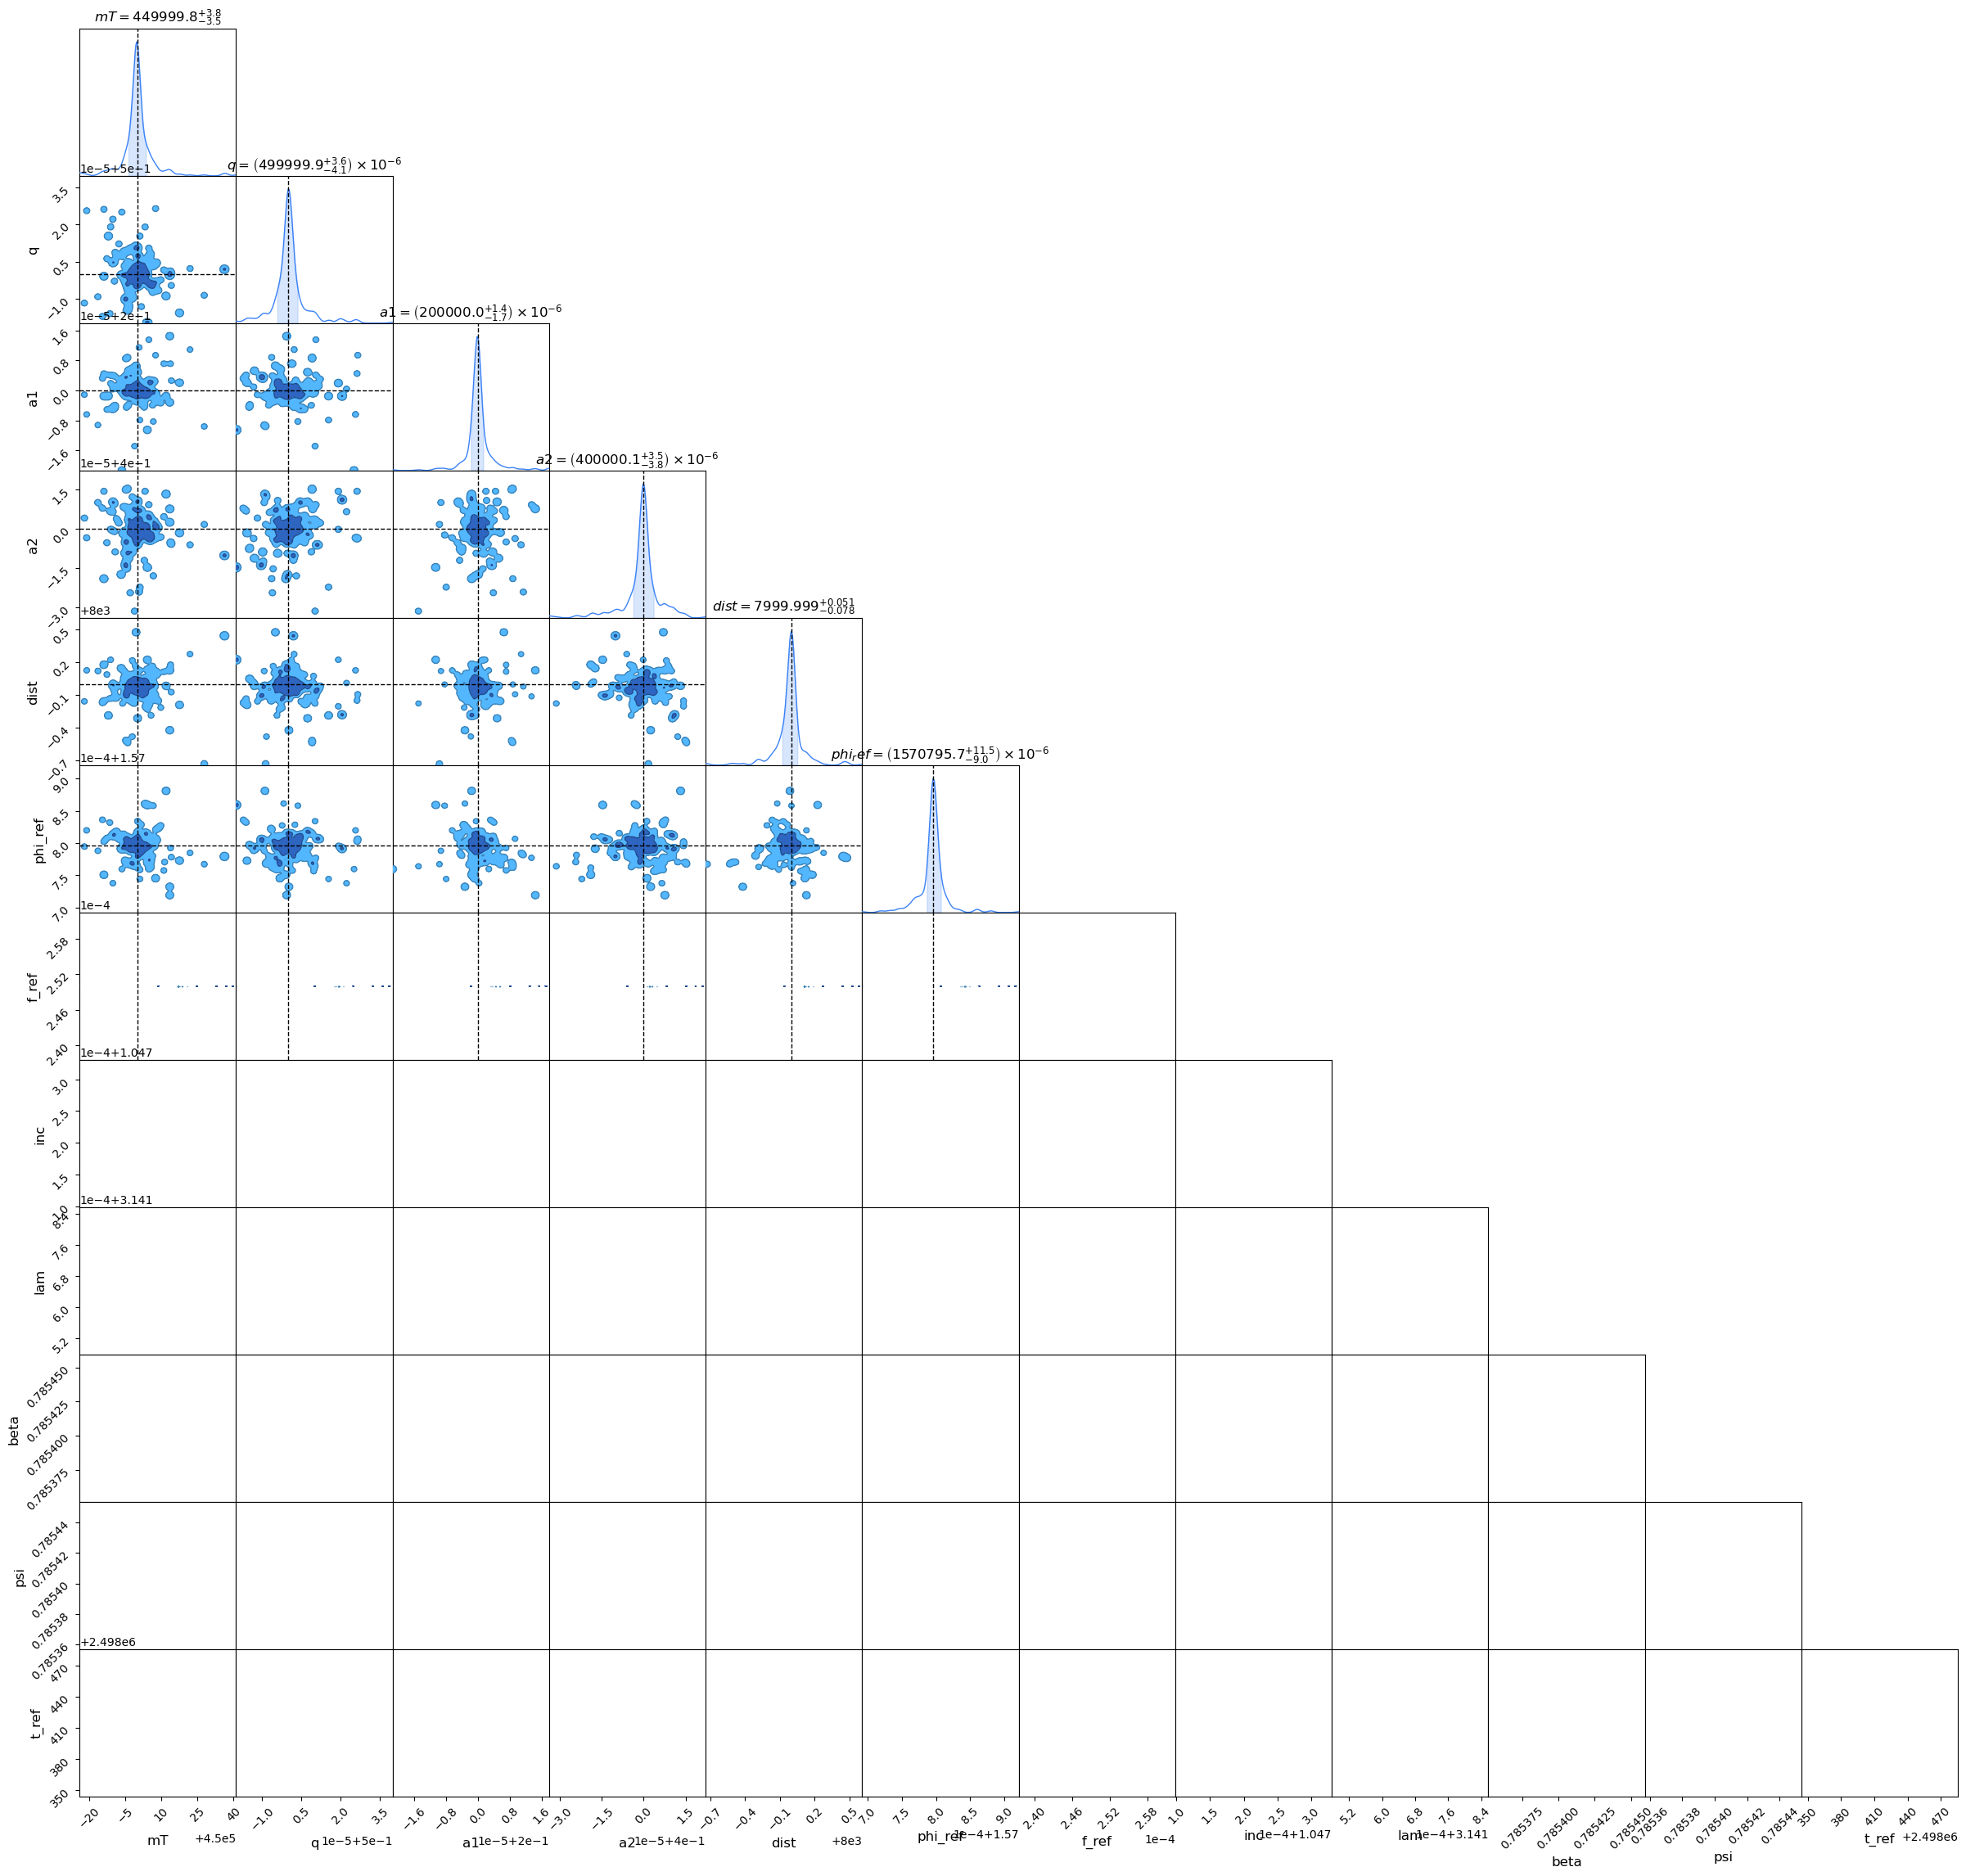

In [ ]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = sampler.get_chain()["mbh"][:, 0].reshape(-1, 12)
df = pd.DataFrame(samples, columns=['mT',
                                    'q',
                                    'a1',
                                    'a2',
                                    'dist',
                                    'phi_ref',
                                    'f_ref',
                                    'inc',
                                    'lam',
                                    'beta',
                                    'psi',
                                    't_ref'])
c = ChainConsumer() 
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT"        : injection_params_sub[0],
                            "q"         : injection_params_sub[1], 
                            "a1"        : injection_params_sub[2],
                            "a2"        : injection_params_sub[3],
                            "dist"      : injection_params_sub[4],
                            "phi_ref"   : injection_params_sub[5],
                            "f_ref"     : injection_params_sub[6],
                            "inc"       : injection_params_sub[7],
                            "lam"       : injection_params_sub[8],
                            "beta"      : injection_params_sub[9],
                            "psi"       : injection_params_sub[10],
                            "t_ref"     : injection_params_sub[11]}))
fig = c.plotter.plot()

In [28]:
df

,mT,q,a1,a2,dist,phi_ref,f_ref,inc,lam,beta,psi,t_ref
0,450000.090546,0.500000,0.200000,0.399999,8000.003101,1.570800,0.0,1.047199,3.141590,0.785398,0.785399,2.498356e+06
1,449999.423413,0.500001,0.200000,0.399999,7999.988972,1.570796,0.0,1.047198,3.141601,0.785397,0.785396,2.498354e+06
2,449999.881119,0.500000,0.200000,0.400000,8000.009084,1.570798,0.0,1.047199,3.141595,0.785398,0.785398,2.498353e+06
3,449999.423060,0.500000,0.200000,0.400000,8000.009858,1.570794,0.0,1.047197,3.141592,0.785398,0.785400,2.498351e+06
4,449998.758379,0.500000,0.200000,0.400000,7999.994199,1.570798,0.0,1.047193,3.141600,0.785395,0.785398,2.498357e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
315,449983.693656,0.499991,0.199991,0.400010,8000.121090,1.570788,0.0,1.047193,3.141574,0.785397,0.785395,2.498435e+06
316,449999.463337,0.499995,0.200006,0.400007,8000.474407,1.570777,0.0,1.047186,3.141598,0.785406,0.785417,2.498373e+06
317,449987.910193,0.500015,0.199998,0.399966,7999.716628,1.570638,0.0,1.047090,3.141713,0.785420,0.785373,2.498405e+06
318,450027.705449,0.499991,0.199990,0.400002,7999.274619,1.570767,0.0,1.047234,3.141599,0.785316,0.785379,2.498465e+06


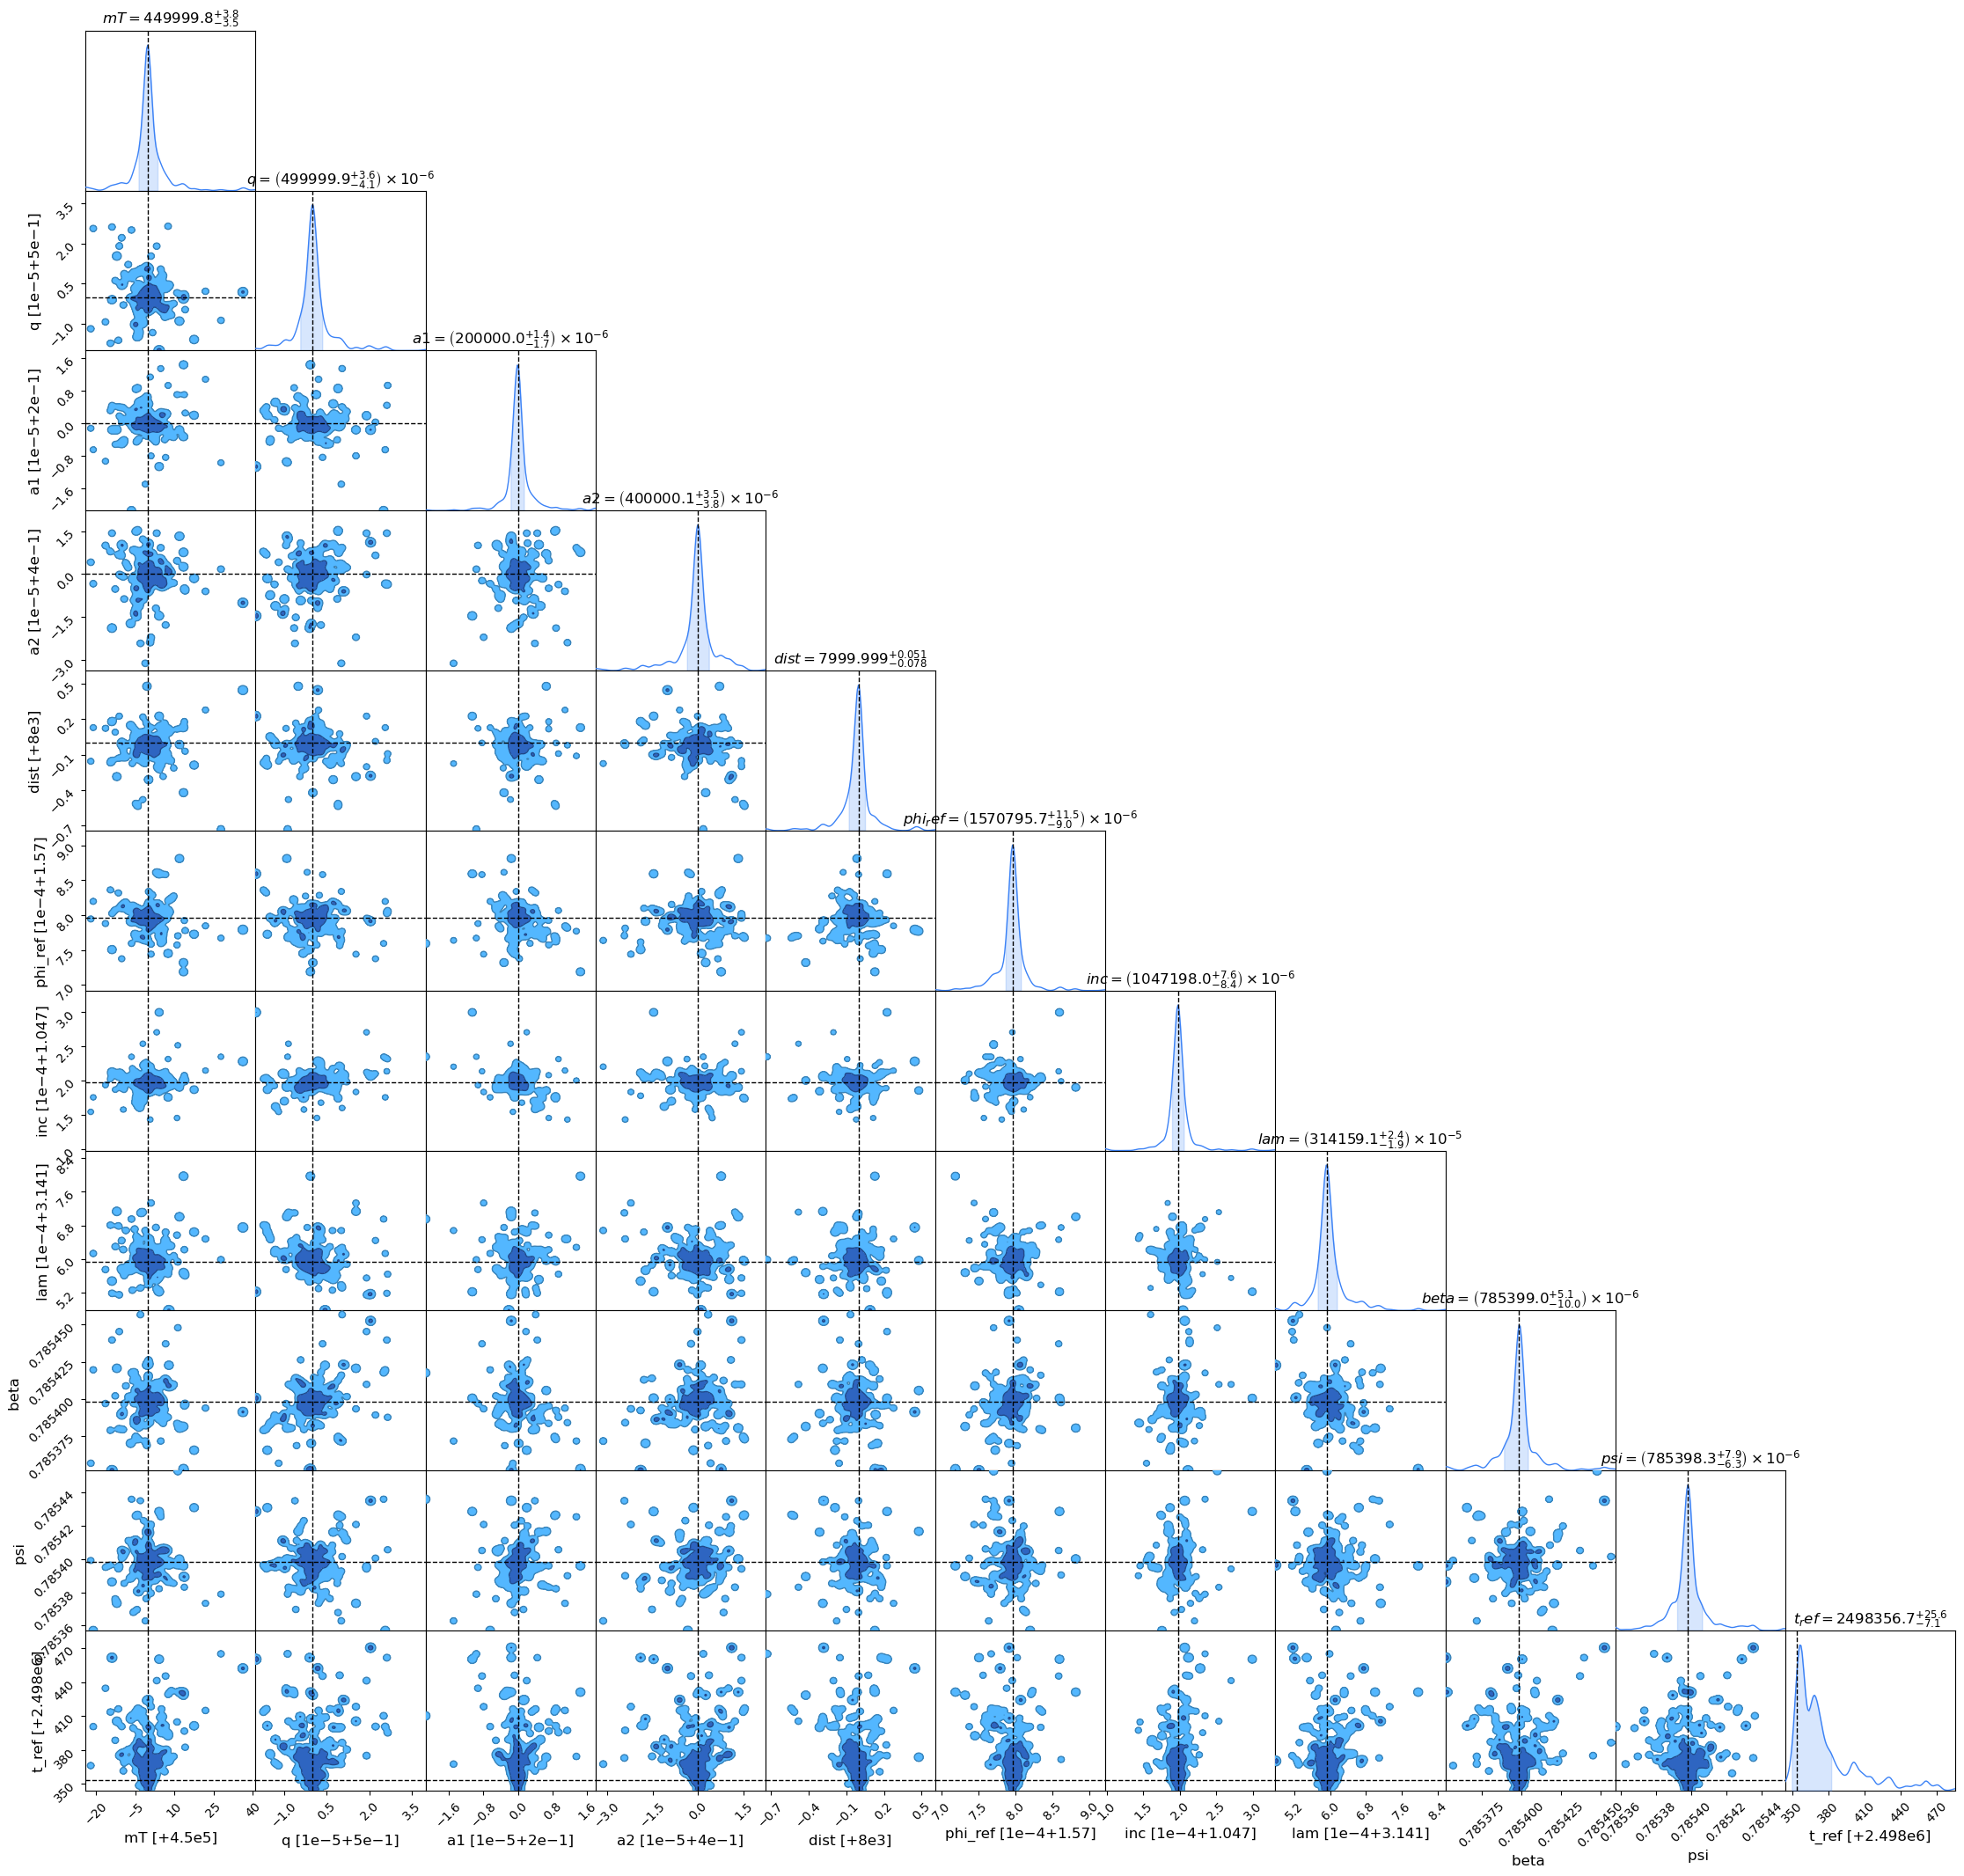

In [27]:
df_new = df.drop(columns=['f_ref'])
c_new = ChainConsumer() 
c_new.add_chain(Chain(samples=df_new, name="An Example Contour"))
c_new.add_truth(Truth(location={"mT"        : injection_params_sub[0],
                            "q"         : injection_params_sub[1], 
                            "a1"        : injection_params_sub[2],
                            "a2"        : injection_params_sub[3],
                            "dist"      : injection_params_sub[4],
                            "phi_ref"   : injection_params_sub[5],
                            #"f_ref"     : injection_params_sub[6],
                            "inc"       : injection_params_sub[7],
                            "lam"       : injection_params_sub[8],
                            "beta"      : injection_params_sub[9],
                            "psi"       : injection_params_sub[10],
                            "t_ref"     : injection_params_sub[11]}))
fig = c_new.plotter.plot()